# Rendu de TD Reconnaissances d'entités nommées avec une approche transformers 

Alexis Mérienne

### Les imports

In [134]:
from transformers import pipeline
import pandas as pd
import tensorflow as tf
from datasets import Dataset,DatasetDict
import numpy as np
from tensorflow.keras.utils import plot_model

In [62]:
model_name = "distilbert-base-uncased"
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## I. Preprocessing

### I.a Le dataset


Le dataset est composée de phrases en anglais pour lesquelles certains mots sont labélisés. 

Les labels sont :

 * personnes (**PER**), 
 * lieux (**LOC**) 
 * organisations (**ORG**)
 * autres (**O**)
 

In [171]:
'''
Le fichier texte contenant les données est structuré de la sorte :

- Une ligne contient un mot ainsi que ces labels
- Les phrases sont séparées d'une ligne blanche

ex : 

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O


_read_dataset lit le dataset en paramètre et stocke les phrases dans une liste, sous la forme d'un tuple (mots,position_tag,ner_tag)
'''
def _read_dataset(filepath):
        with open(filepath, encoding="utf-8") as f:
            sents = {
                "sentences" : [],
                "ner_tags" : []
            }
            sent = []
            ner_tags = []
            for line in f:
                if line.startswith("-DOCSTART-") or line == "" or line == "\n":
                   
                    sents["sentences"].append(sent)
                    sents["ner_tags"].append(ner_tags)
                    sent = []
                    ner_tags = []
                else:
                    splits = line.split(" ")
                    token = splits[0]
                    pos_tag = splits[1]
                    ner_tag = splits[3].rstrip()
                    if 'MISC' in ner_tag:
                        ner_tag = 'O'
                    
                    sent.append(token)
                    ner_tags.append(ner_tag)
        return sents               

In [172]:
train_sents = _read_dataset('NER Dataset/train.txt')
validation_sents = _read_dataset('NER Dataset/test.txt')

train_sentences = train_sents["sentences"]
train_ner_tags = train_sents["ner_tags"]
n_train = len(train_ner_tags)

In [173]:
test_sentences = validation_sents["sentences"]
test_ner_tags = validation_sents["ner_tags"]
n_test = len(test_ner_tags)

### I.B Les tags de reconnaissance d'entités nommées

Dans cette partie, nous nous intéressons à convertir les tags NER en id numérique. Cette étape est importante car pour la tokenisation des inputs du modèle, le format des données d'entrées des tags NER sont des entiers, représentant leur ids.

Ainsi, la solution que nous avons choisi dans ce notebook est d'ajouter une *key* dans les dictionnaires des données d'entrées contenant les labels sous format d'entiers. 

In [174]:
all_ner_tags = []
for s in ner_tags:
    for t in s:
        all_ner_tags.append(t)

In [175]:
label_names = list(set(all_ner_tags))
label_names

['I-ORG', 'B-ORG', 'B-LOC', 'O', 'I-PER', 'B-PER', 'I-LOC']

In [204]:
#convertit les labels NER en id
label2id = {label:i for i, label in enumerate(label_names)}
#Nous verrons par la suite à quoi sert le tag "SEP/CLS", qui n'est pas encore présent dans nos données
label2id["SEP/CLS"] = -100

#convertit les id en labels
id2label = {v: k for k, v in label2id.items()}

nb_labels = len(label_names)

In [177]:
label2id

{'I-ORG': 0,
 'B-ORG': 1,
 'B-LOC': 2,
 'O': 3,
 'I-PER': 4,
 'B-PER': 5,
 'I-LOC': 6,
 'SEP/CLS': -100}

In [178]:
#renvoie la liste d'id de la liste de labels NER donné en paramètre
def convert_tag_to_label(ner_tags):
    labels=[]
    for el in ner_tags:
        labels.append(label2id[el])
        
    return labels   

In [179]:
#On construit la liste des ids pour les données d'entrainement. 
train_labels = []
for tag in train_ner_tags:
    train_labels.append(convert_tag_to_label(tag))
train_ner_tags[2],train_labels[2]

(['B-ORG', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'],
 [1, 3, 3, 3, 3, 3, 3, 3, 3])

In [180]:
#On construit la liste des ids pour les données de test. 
test_labels = []
for tag in val_ner_tags:
    test_labels.append(convert_tag_to_label(tag))

### I.C Construction du dataset

Ici, on convertit nos données sous la forme de dictionnaires dont les attributs sont "sentences", qui sont la liste des phrases présentes dans le dataset, "ner_tags", les tags associés à ces phraseset labels, les ids de ces tags. 

On divise en ensuite les données d'entrainements en deux jeu de données : 

        - Les données sur lesquelles le modèles va apprendre
        - Les données de validation
        
Le ratio de cette division est 80% pour les données d'entrainement, 20% pour les données de validation. Ce choix provient du fait que ce ratio est plus présent dans la littérature. 


In [185]:
#https://huggingface.co/docs/datasets/tabular_load

df_train = pd.DataFrame({"sentences":train_sentences,"ner_tags":train_ner_tags,"labels":train_labels})
#df_train = df.drop([0,1])

df_test = pd.DataFrame({"sentences":test_sentences,"ner_tags":test_ner_tags,"labels":test_labels})
#df_val = df.drop([0,1])

df_train=df_train.drop([0,1])
df_test=df_test.drop([0,1])

df_train, df_val = np.array_split(
    df_train, (np.array([0.8,0.2])[:-1].cumsum() * len(df_train)).astype(int))

df_train.head()

,sentences,ner_tags,labels
2,"[EU, rejects, German, call, to, boycott, Briti...","[B-ORG, O, O, O, O, O, O, O, O]","[1, 3, 3, 3, 3, 3, 3, 3, 3]"
3,"[Peter, Blackburn]","[B-PER, I-PER]","[5, 4]"
4,"[BRUSSELS, 1996-08-22]","[B-LOC, O]","[2, 3]"
5,"[The, European, Commission, said, on, Thursday...","[O, B-ORG, I-ORG, O, O, O, O, O, O, O, O, O, O...","[3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
6,"[Germany, 's, representative, to, the, Europea...","[B-LOC, O, O, O, O, B-ORG, I-ORG, O, O, O, B-P...","[2, 3, 3, 3, 3, 1, 0, 3, 3, 3, 5, 4, 3, 3, 3, ..."


In [187]:
#On construit ensuite le dataset, composé de nos 3 jeu de données : train, validation, test
ner_dataset_train = Dataset.from_pandas(df_train)
ner_dataset_validation = Dataset.from_pandas(df_val) 
ner_dataset_test = Dataset.from_pandas(df_test)
ner_dataset = DatasetDict({"train":ner_dataset_train,"validation":ner_dataset_validation,"test":ner_dataset_test})
ner_dataset

DatasetDict({
    train: Dataset({
        features: ['sentences', 'ner_tags', 'labels'],
        num_rows: 12744
    })
    validation: Dataset({
        features: ['sentences', 'ner_tags', 'labels'],
        num_rows: 3186
    })
    test: Dataset({
        features: ['sentences', 'ner_tags', 'labels'],
        num_rows: 3912
    })
})

In [188]:
ner_dataset["train"][0]["sentences"]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [189]:
ner_dataset["train"][0]["labels"]

[1, 3, 3, 3, 3, 3, 3, 3, 3]

In [190]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Début d'un nouveau mot
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Token de séparation
            new_labels.append(-100)
        else:
            # Même mot que le token précédent
            label = labels[word_id]
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [191]:
inputs = tokenizer(ner_dataset["train"][0]["sentences"], is_split_into_words=True)
inputs.tokens()

labels = ner_dataset["train"][0]["labels"]
word_ids = inputs.word_ids()
print(labels)
print(align_labels_with_tokens(labels, word_ids))

[1, 3, 3, 3, 3, 3, 3, 3, 3]
[-100, 1, 3, 3, 3, 3, 3, 3, 3, 3, -100]


### I.D Tokenizer

On crée une fonction que l'on appelle dans le tokenizer pour aligner les ids des labels NER avec les phrases. 

La tokenisation est une étape cruciale de notre pipeline de données. En effet, elle nous permet de traduire le texte en données intérprétable par le modèle. 

Les librairie transformer proposent des tokenizers pré-entrainé sur le modèle choisit. Nous utilisons ici celui de "distilbert-base-uncased". Sa fonction est de construire un mapping entre les mots en anglais et des ids corresondants.  

In [123]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["sentences"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["labels"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [192]:
tokenized_datasets = ner_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=ner_dataset["train"].column_names,
)

  0%|          | 0/13 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

## II. Le modèle transformer

In [193]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors="tf"
)

In [205]:
#On test ici si le data_collector convertit bien les données tokenisées en tenseur. 
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

<tf.Tensor: shape=(2, 11), dtype=int64, numpy=
array([[-100,    1,    3,    3,    3,    3,    3,    3,    3,    3, -100],
       [-100,    5,    4, -100, -100, -100, -100, -100, -100, -100, -100]],
      dtype=int64)>

In [201]:
#On transforme nos trois jeux de données en tenseur, qui sont des objets intérprétables par le modèle
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    collate_fn=data_collator,
    shuffle=True,
    batch_size=16,
)

tf_eval_dataset = tokenized_datasets["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "labels"],
    collate_fn=data_collator,
    shuffle=False,
    batch_size=16,
)


In [196]:
from transformers import TFAutoModelForTokenClassification

input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="attention_mask")

model = TFAutoModelForTokenClassification.from_pretrained(
    model_name,
    id2label=id2label,
    label2id=label2id,
    return_dict=True,           
    output_hidden_states=False, 
    output_attentions=False, 
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForTokenClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'dropout_79']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferenc

In [197]:
from transformers import create_optimizer

num_epochs = 3
num_train_steps = len(tf_train_dataset) * num_epochs

optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=0.01,
)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [198]:
model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    epochs=num_epochs,
)

Epoch 1/3
797/797 [==============================] - 2526s 3s/step - loss: 0.2055 - val_loss: 0.0891
Epoch 2/3
797/797 [==============================] - 34769s 44s/step - loss: 0.0455 - val_loss: 0.0821
Epoch 3/3
797/797 [==============================] - 1933s 2s/step - loss: 0.0289 - val_loss: 0.0828


In [152]:
#!pip install seqeval

ERROR: Invalid requirement: 'seqeval`'


In [206]:
from seqeval.metrics import classification_report

import numpy as np

all_pred = []
all_true = []
for batch in tf_test_dataset:
    logits = model.predict(batch)["logits"]
    labels = batch["labels"]
    predictions = np.argmax(logits, axis=-1)
    for prediction, label in zip(predictions, labels):
        p_ = []
        t_ = []
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == label2id["SEP/CLS"]:
                continue
            p_.append(label_names[predicted_idx])
            t_.append(label_names[label_idx])
        all_pred.append(p_)
        all_true.append(t_)

In [207]:
print(classification_report(all_pred, all_true))

              precision    recall  f1-score   support

         LOC       0.94      0.91      0.92      3908
         ORG       0.87      0.83      0.85      1846
         PER       0.95      0.96      0.96      5745

   micro avg       0.93      0.92      0.93     11499
   macro avg       0.92      0.90      0.91     11499
weighted avg       0.93      0.92      0.93     11499



## III. Conclusion

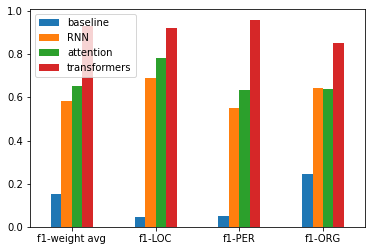

In [208]:
#Les données 'baseline', 'RNN' et 'attention' proviennent des approches étudiés lors du rendu précédent. 
result = {
    "baseline" : [0.150,0.047,0.049,0.246],
    "RNN" : [0.584,0.690, 0.551, 0.645],
    "attention" :  [0.651,0.781, 0.636, 0.640],
    "transformers": [0.93,0.92,0.96,0.85]
}

index = ['f1-weight avg', 'f1-LOC', 'f1-PER','f1-ORG']

df = pd.DataFrame(result, index=index)
ax = df.plot.bar(rot=0)